# Readme Seymour 
#### By Heather McMillan
#### Desiree McElroy
#### Carl Griffin



In [2]:
import pandas as pd
import numpy as np
import unicodedata
import re
import nltk

# imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm # for colormap tools
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# import modules 
import prepare as p
import acquire as a
import explore as ex
import model as m

# imports for NLP extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
sns.set_palette('viridis')

## Overview and Goals
The goal of this project is to determine the main coding language of a project based on the contents of it's github Readme, using NLP methods. The data was acquired from various repositories on Github. In order to recreate this project you will need to access the json of the data we acquired. During the acquisition of the repo names, we filtered for the word customer, not for any particular reason other than something to filter for. 

A total of 193 Repos were obtained but after dropping nulls, readmes with Chinese characters, and slimming it down to the top most prevalent languages in our dataset we ended up with data from 106 different documents. The 4 languages that we filtered for were, Java, JavaScript, PHP, and Jupyter Notebook. 

## Findings
We found that an SVC model using Lemmatized data, and  performed the highest with an accuracy of 81% on the validate data set (unseen). With a final test accuracy of INSERT NUMBER HERE. 



In [3]:
# read in data from Json
df = pd.read_json('data2.json')

# take a peak at it
df.head()

,repo,language,readme_contents
0,codingXiaxw/CustomerManagement,Java,## JavaWeb项目之客户管理系统 \n\n## 项目介绍\n详细讲解请点击这里前往我的...
1,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...
2,Tophold/FinancialCustomerView,Java,## FinancialCustomerView\n* 本项目会对金融交易软件中存在的各种V...
3,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...
4,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...


It looks like we have some Chinese in here. Let's take a look at the different coding languages we have.

In [6]:
df.language.value_counts(dropna = False)

PHP                 41
Jupyter Notebook    32
JavaScript          25
Java                23
Python              20
C#                  12
NaN                  7
TypeScript           4
R                    4
HTML                 4
Vue                  3
Go                   3
Ruby                 3
HCL                  2
Dart                 2
CSS                  2
PowerShell           2
Objective-C          1
Scala                1
Shell                1
Swift                1
ABAP                 1
Name: language, dtype: int64

Since we have so many different types of languages here let's take the top 4 and filter for those. Maybe in a later model we can come back and create models for some other languages.

In [9]:
# we're going to drop chinese rows, unused languages, and any empty languages if we have any
df = p.drop_unneeded_data(df)

# we'll also prepare the data for NLP processing dropping a few words 
# that were present in almost all the readmes
df = p.prepare_nlp_data(df, content = 'readme_contents', extra_words=['customer', 'customers', '1', '2'])

In [17]:
# take a look at what we have remaining
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             106 non-null    object
 1   language         106 non-null    object
 2   readme_contents  106 non-null    object
 3   clean            106 non-null    object
 4   stemmed          106 non-null    object
 5   lemmatized       106 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB


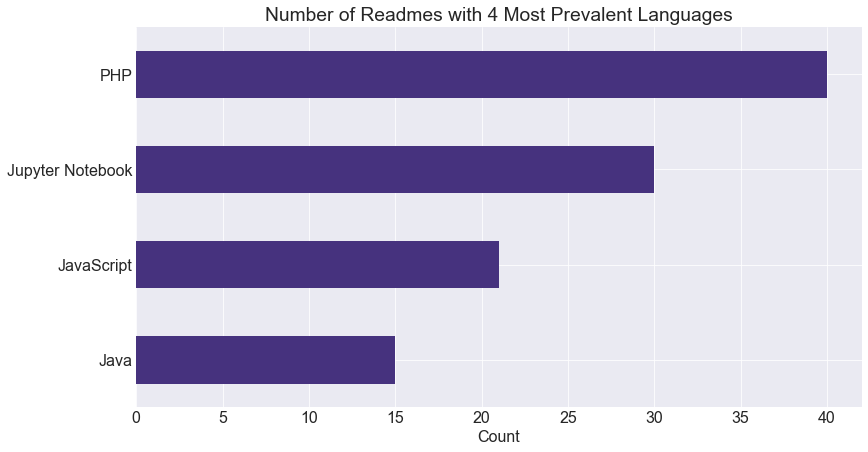

In [16]:
df.language.value_counts().sort_values(ascending = True).plot.barh()
plt.title('Number of Readmes with 4 Most Prevalent Languages')
plt.xlabel("Count")
plt.show()

In [18]:
# data is now cleaned lemmatized and stemmed for us to explore with
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
0,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...,manager angularjs custom routing dynamic contr...,manag angularj custom rout dynam control scrip...,manager angularjs custom routing dynamic contr...
1,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...,manager angularjs youre new angularjs check an...,manag angularj your new angularj check angular...,manager angularjs youre new angularjs check an...
2,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...,rest based microservices sample three spring b...,rest base microservic sampl three spring boot ...,rest based microservices sample three spring b...
3,eventuate-tram/eventuate-tram-examples-custome...,Java,# Eventuate Tram Customers and Orders\n\nThis ...,eventuate tram orders application demonstrates...,eventu tram order applic demonstr two key patt...,eventuate tram order application demonstrates ...
4,Featuretools/predict-customer-churn,Jupyter Notebook,# A Machine Learning Framework with an Applica...,machine learning framework application predict...,machin learn framework applic predict churn im...,machine learning framework application predict...


## Exploration
In this section we find that bigrams and trigrams across the different languages are fairly different while there are very few words that are 100% specific to one language or another. With a few exceptions being 'magento' found only in jupyter notebooks, and funnily the word 'notebook' is only in PHP. The word 'model' is found in PHP readmes 95% of the time. And the word 'extension' is mostly in Jupyter Notebooks but only found elsewhere in Java readmes.

We also decided to add the words customer, customers, 1, and 2 to the stopwords. They were removed in the prepare function.

In [19]:
# split in to train validate and test groups
train, validate, test = p.split_data(df)

train---> (58, 6)
validate---> (26, 6)
test---> (22, 6)


In order to see the percentages of all the words we first have to obtain counts of all the words in the text in order to visualize. We joined all the text from the readmes of the same language together, split it up into words, then did a value counts.

In [21]:
all_word_counts = ex.get_word_counts_series(train, 'lemmatized')
java_word_counts = ex.get_word_counts_series(train[train.language == 'Java'], 'lemmatized')
javascript_word_counts = ex.get_word_counts_series(train[train.language == 'JavaScript'], 'lemmatized')
php_word_counts = ex.get_word_counts_series(train[train.language == 'PHP'], 'lemmatized')
jupyter_word_counts = ex.get_word_counts_series(train[train.language == 'Jupyter Notebook'], 'lemmatized')

In [22]:
# create list of all the previous counts
word_counts_list = [java_word_counts, javascript_word_counts, php_word_counts, jupyter_word_counts, all_word_counts]

# create list of names for columns
column_names = list(df.language.unique())
column_names.append('all')

# create list of languages
languages = list(df.language.unique())

In [24]:
# create dataframe of the counts for graphing later
word_counts = pd.concat(word_counts_list, axis=1).fillna(0).astype(int)
word_counts.columns = column_names
word_counts.head()

,JavaScript,Java,Jupyter Notebook,PHP,all
service,126,9,4,20,159
order,116,4,29,5,154
saga,58,0,0,0,58
using,47,23,25,55,150
application,36,23,3,13,75


<Figure size 1152x648 with 0 Axes>

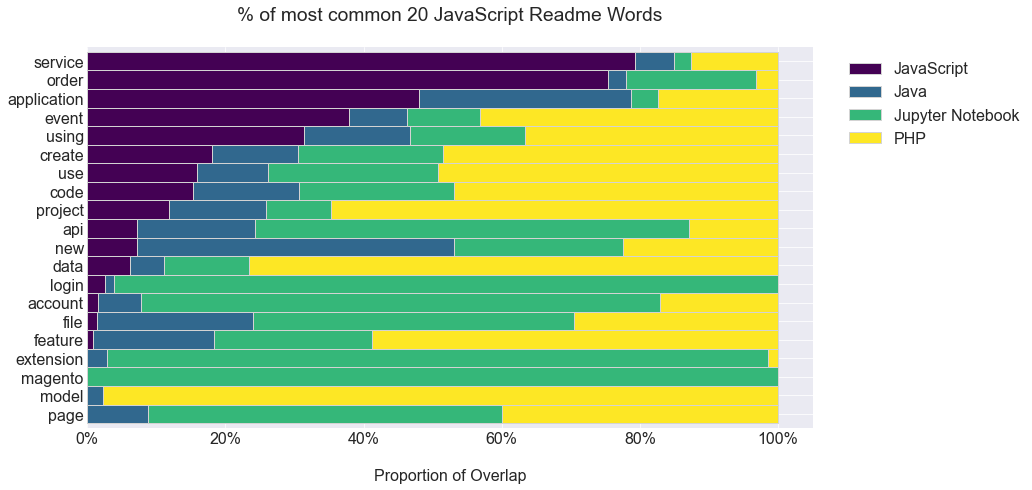

<Figure size 1152x648 with 0 Axes>

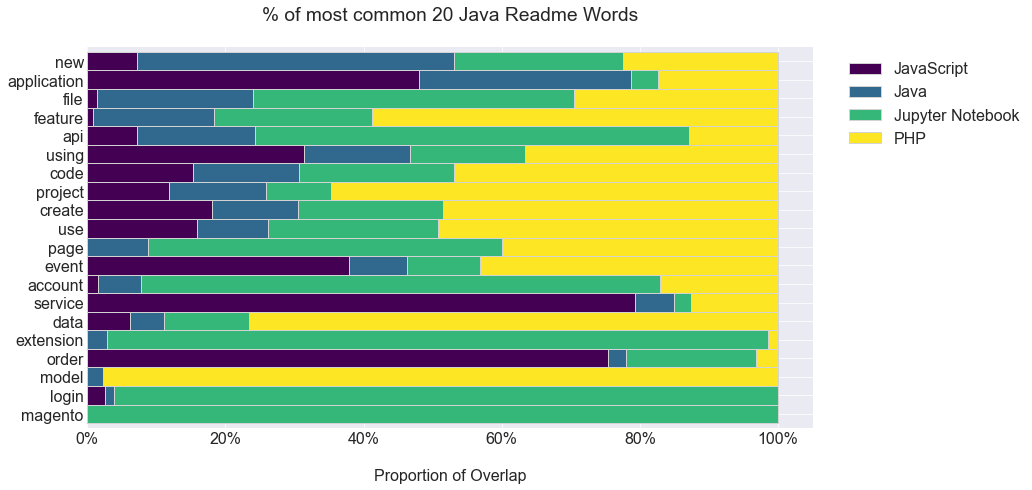

<Figure size 1152x648 with 0 Axes>

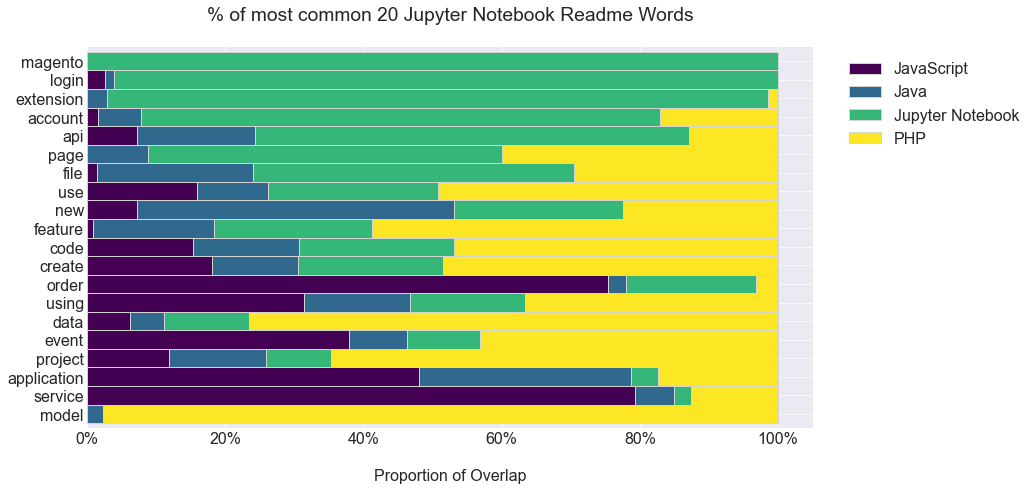

<Figure size 1152x648 with 0 Axes>

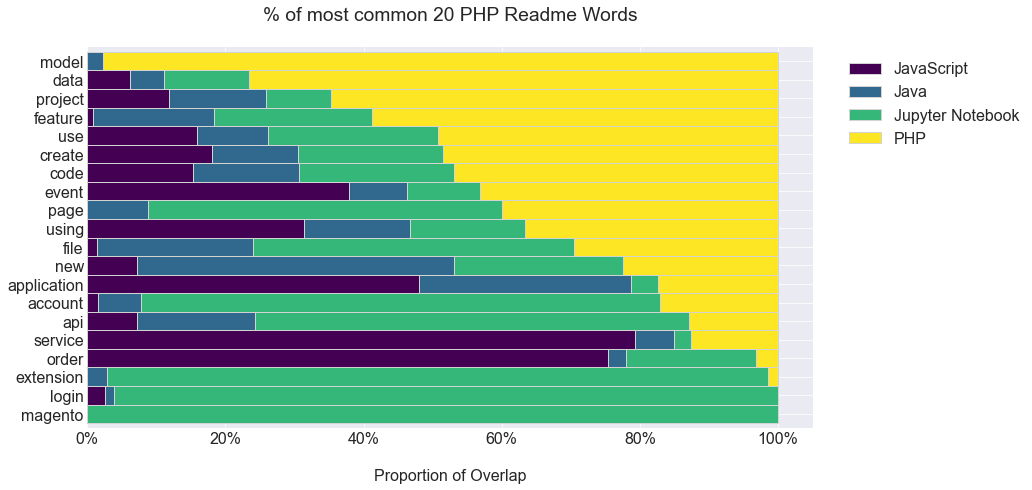

In [28]:
for language in languages:
    ex.plot_overlap_stacked_bar(word_counts, language, cmap = 'viridis')

In [29]:
# create words lists
words = ' '.join(train['lemmatized'])
all_words = words.split()

words = ' '.join(train[train.language == 'JavaScript']['lemmatized'])
javascript_words = words.split()

words = ' '.join(train[train.language == 'Java']['lemmatized'])
java_words = words.split()

words = ' '.join(train[train.language == 'PHP']['lemmatized'])
php_words = words.split()

words = ' '.join(train[train.language == 'Jupyter Notebook']['lemmatized'])
jupyter_words = words.split()


all_the_words_list = [javascript_words, java_words, jupyter_words, php_words, all_words]

-------------------------------------------------JavaScript---------------------------------------------------------


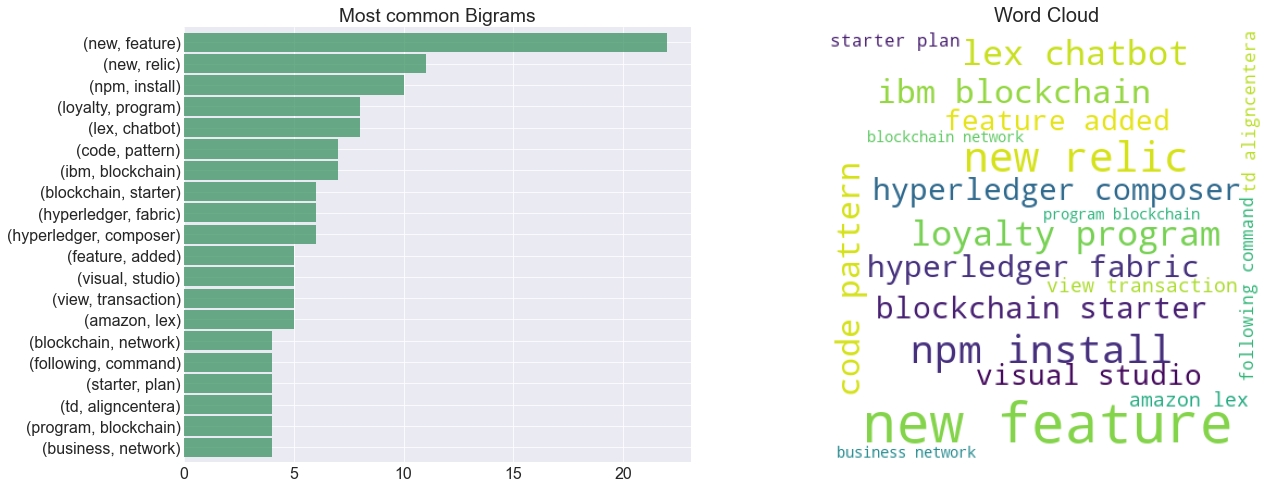

-------------------------------------------------Java---------------------------------------------------------


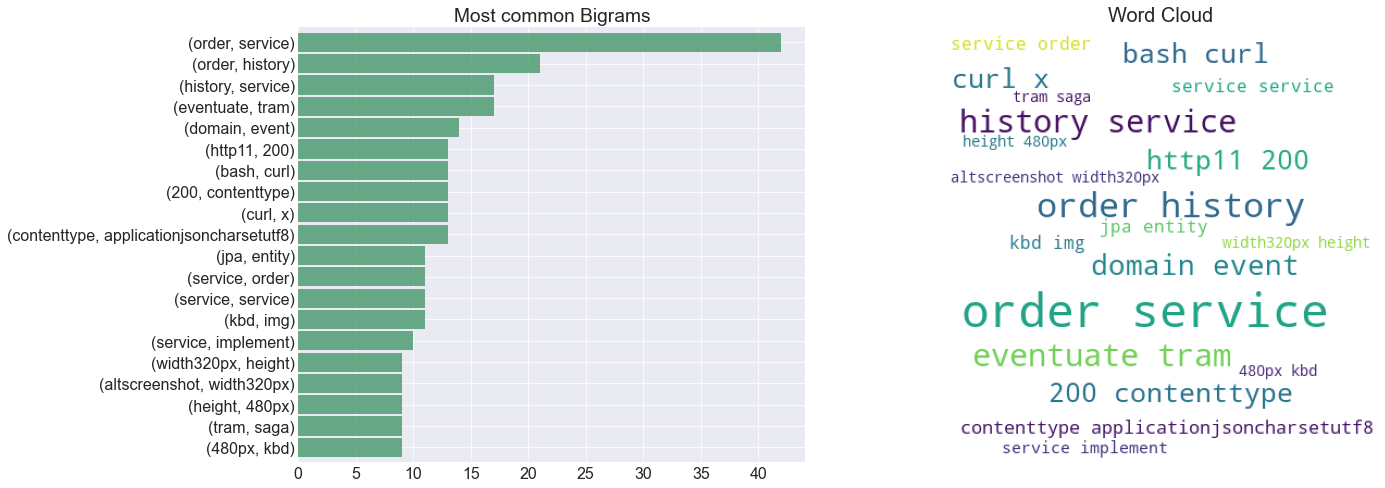

-------------------------------------------------Jupyter Notebook---------------------------------------------------------


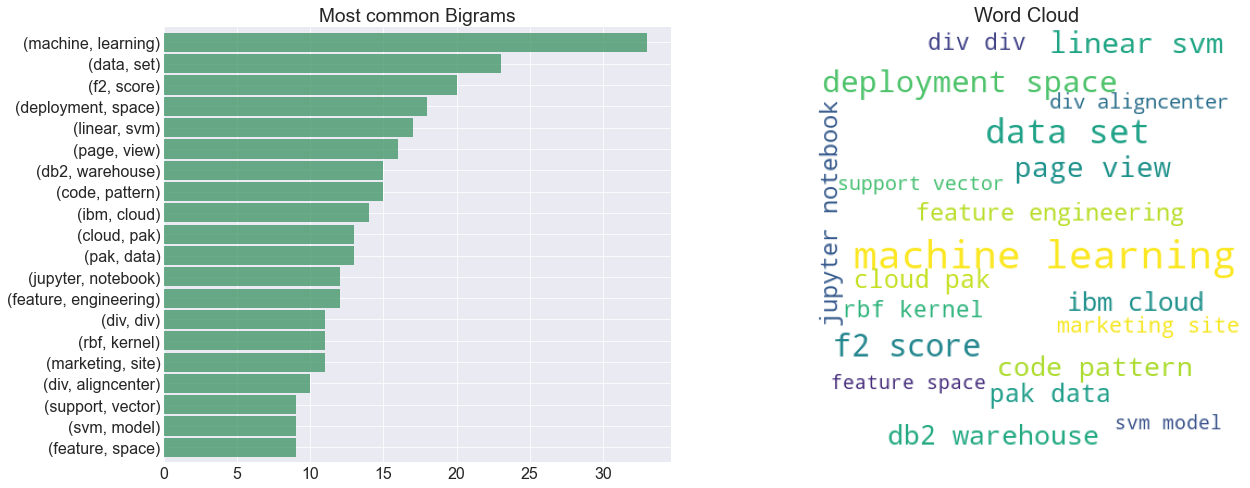

-------------------------------------------------PHP---------------------------------------------------------


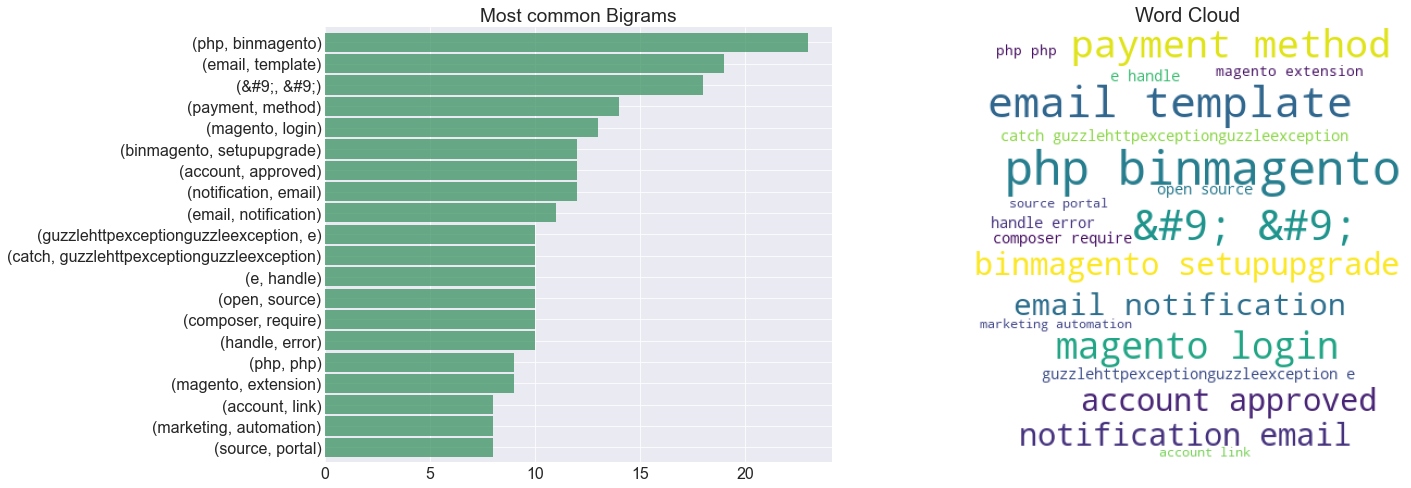

-------------------------------------------------all---------------------------------------------------------


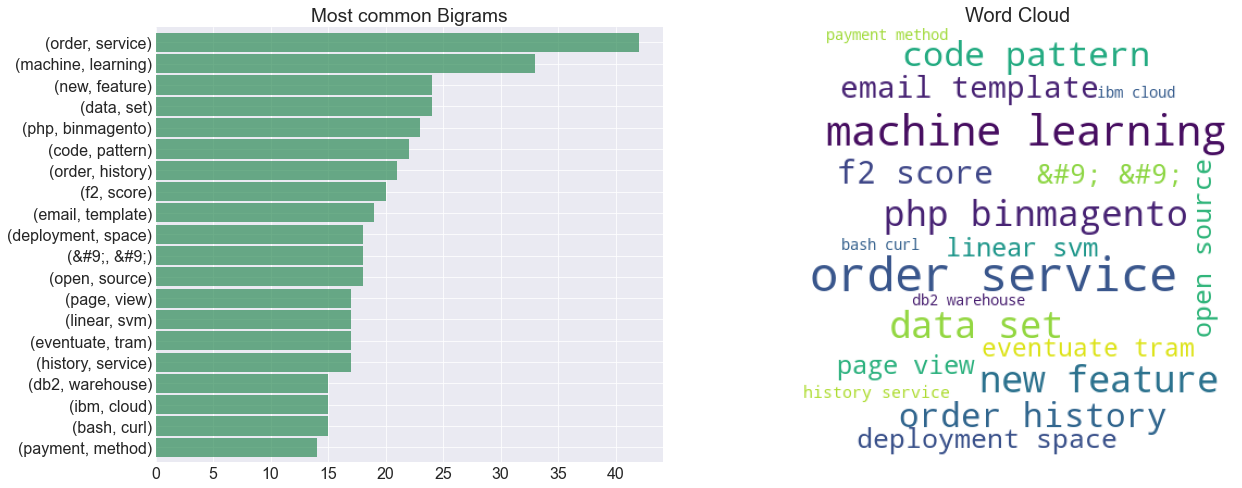

In [30]:
for x, name in zip(all_the_words_list, column_names):
    print(f'-------------------------------------------------{name}---------------------------------------------------------')
    ex.bigram_count_word_cloud(x)